In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score


from pep_modules import patientai as pai

In [13]:
def important_chi2events(freq_df, targets_df, flags_col_name):
    chi2_scores, p_values = chi2(freq_df, targets_df[flags_col_name])
    chi2_df = pd.DataFrame({'event_code': freq_df.columns, 'chi2': chi2_scores, 'p_value': p_values})
    sorted_chi2 = chi2_df.sort_values('p_value').reset_index(drop=True)
    imp_events = sorted_chi2[sorted_chi2['p_value']<=0.05]['event_code'].tolist()
    return imp_events

def plot_roc_curve(y_true, y_score, roc_auc_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(10,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
df_new_seq = pd.read_pickle(r'../data/pat_journey_rx_px_dx.pkl')

In [4]:
df_new_seq.shape, df_new_seq.pat_id.nunique()

((4622362, 8), 45980)

In [5]:
df_new_seq.dtypes

pat_id                int64
ICD9_CODE            object
seq_num_modified    float64
type                 object
seq_num_final         int64
cohort               object
switch_flag           int64
HADM_ID_lst          object
dtype: object

In [6]:
df_new_seq.ICD9_CODE.nunique()

13227

In [7]:
df_new_seq.head()

,pat_id,ICD9_CODE,seq_num_modified,type,seq_num_final,cohort,switch_flag,HADM_ID_lst
0,2,NEO*IV*Gentamicin,1.0,rx,1,c1,0,[163353]
1,2,Syringe (Neonatal) *D5W*,2.0,rx,2,c1,0,[163353]
2,2,Ampicillin Sodium,3.0,rx,3,c1,0,[163353]
3,2,Send 500mg Vial,4.0,rx,4,c1,0,[163353]
4,2,9955.0,1.0,px,5,c1,0,[163353]


In [8]:
# journey lengths
df_new_seq.groupby('pat_id')['seq_num_final'].max().describe()

count    45980.000000
mean       100.529839
std        114.488159
min          1.000000
25%         28.000000
50%         72.000000
75%        129.000000
max       2285.000000
Name: seq_num_final, dtype: float64

In [9]:
freq_df = pai.get_frequencies(df_new_seq,'pat_id','ICD9_CODE')

In [31]:
freq_df = freq_df.fillna(0)

In [32]:
targets = pd.read_pickle(r'../data/target.pkl')

In [33]:
imp_events = important_chi2events(freq_df, targets, 'switch_flag')

In [34]:
df_imp = freq_df[imp_events]

In [40]:
x_train_static = pd.read_pickle(r'../data/train_static.pkl')
x_val_static = pd.read_pickle(r'../data/val_static.pkl')
x_test_static = pd.read_pickle(r'../data/test_static.pkl')

X1, X_test, y1, y_test = train_test_split(df_imp, targets, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.15, random_state=42)

# Count and Provided Features

In [48]:
x_trn = np.concatenate([x_train_static.values, X_train.values], axis=1)
x_val = np.concatenate([x_val_static.values, X_val.values], axis=1)
x_tst = np.concatenate([x_test_static.values, X_test.values], axis=1)

In [52]:
X_train_sparse = csr_matrix(x_trn)
X_val_sparse = csr_matrix(x_val)
X_test_sparse = csr_matrix(x_tst)

In [51]:
x_trn.shape, x_val.shape, x_tst.shape

((31266, 1921), (5518, 1921), (9196, 1921))

In [53]:
classifier = LogisticRegression(random_state=99, solver='saga', max_iter=2000, tol=0.001)
classifier.fit(X_train_sparse, y_train['switch_flag'])

LogisticRegression(max_iter=2000, random_state=99, solver='saga', tol=0.001)

In [54]:
y_train_pred = classifier.predict_proba(X_train_sparse)[:,1]
y_val_pred = classifier.predict_proba(X_val_sparse)[:,1]
y_test_pred = classifier.predict_proba(X_test_sparse)[:,1]

In [55]:
print('Train AUC',roc_auc_score(y_train['switch_flag'], y_train_pred))

Train AUC 0.7887558203156557


In [56]:
print('Val AUC',roc_auc_score(y_val['switch_flag'], y_val_pred))

Val AUC 0.6439139221469989


In [57]:
print('Test AUC',roc_auc_score(y_test['switch_flag'], y_test_pred))

Test AUC 0.7026411036826999


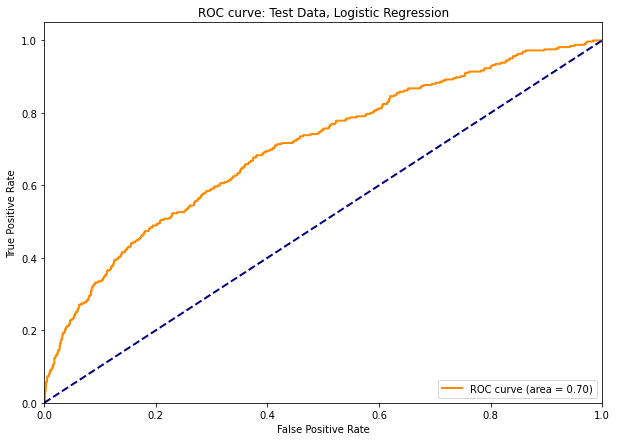

In [58]:
plot_roc_curve(y_test['switch_flag'], y_test_pred, 0.70, 'ROC curve: Test Data, Logistic Regression')

# Only Count

In [59]:
X_train_sparse = csr_matrix(X_train)
X_val_sparse = csr_matrix(X_val)
X_test_sparse = csr_matrix(X_test)

In [60]:
X_train.shape, X_val.shape, X_test.shape

((31266, 1739), (5518, 1739), (9196, 1739))

In [61]:
classifier = LogisticRegression(random_state=99, solver='saga', max_iter=2000, tol=0.001)
classifier.fit(X_train_sparse, y_train['switch_flag'])

LogisticRegression(max_iter=2000, random_state=99, solver='saga', tol=0.001)

In [62]:
y_train_pred = classifier.predict_proba(X_train_sparse)[:,1]
y_val_pred = classifier.predict_proba(X_val_sparse)[:,1]
y_test_pred = classifier.predict_proba(X_test_sparse)[:,1]

In [63]:
print('Train AUC',roc_auc_score(y_train['switch_flag'], y_train_pred))

Train AUC 0.6084123462822897


In [64]:
print('Val AUC',roc_auc_score(y_val['switch_flag'], y_val_pred))

Val AUC 0.5650075863319215


In [65]:
print('Test AUC',roc_auc_score(y_test['switch_flag'], y_test_pred))

Test AUC 0.5490700033818059


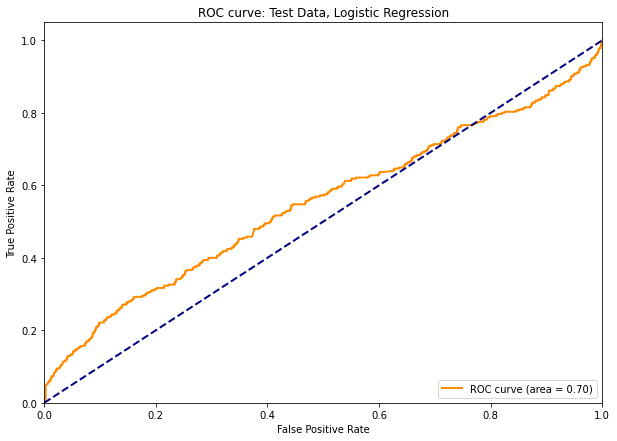

In [66]:
plot_roc_curve(y_test['switch_flag'], y_test_pred, 0.70, 'ROC curve: Test Data, Logistic Regression')